In [33]:
directory = r'Q:\Cameras\TimePix\PyPix-Advacam-TPX3'
filename = 'original.h5'
output_filename = '23-8-24-extracted.h5'

In [34]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import time
from scipy.ndimage import label, center_of_mass
from sklearn.cluster import DBSCAN #scikit-learn
from sklearn.mixture import GaussianMixture

In [35]:
def return_row(dictionary, row_number):
    row = []
    for key in dictionary.keys():
        row.append(dictionary[key][row_number])
    return row

def BinToInt(array):
    return array.dot(1 << np.arange(array.shape[-1]- 1, -1, -1))

def return_x_y(matrix):
    binary_matrix = (((matrix[:,None] & (1 << np.arange(16))[::-1])) > 0)
    column = BinToInt(binary_matrix[:,:7])
    superpixel = BinToInt(binary_matrix[:,8:14])
    pixel = np.hstack((np.reshape(binary_matrix[:,7],(-1,1)), binary_matrix[:,[14,15]]))
    pixel = BinToInt(pixel)
    x = 2 * column + 1
    x[np.where(pixel > 3)] += 1
    y = 4 * superpixel
    y[np.where((pixel == 0) | (pixel == 4))] += 1
    y[np.where((pixel == 1) | (pixel == 5))] += 2
    y[np.where((pixel == 2) | (pixel == 6))] += 3
    y[np.where((pixel == 3) | (pixel == 7))] += 4
    del binary_matrix, column, superpixel, pixel
    return np.array(x), np.array(y)

def grubbs_test(data, alpha):
    """
    Performs the Grubbs test on a one-dimensional dataset.

    Args:
    data: A list or NumPy array of numerical values.
    alpha: The significance level for the test.

    Returns:
    A tuple of (is_outlier, z_statistic, outlier_index).
        - is_outlier: True if an outlier is detected, False otherwise.
        - z_statistic: The calculated Grubbs z-statistic.
        - outlier_index: The index of the outlier if found, None otherwise.
    """
    n = len(data)
    mean = np.mean(data)
    std = np.std(data)

    z_scores = [(abs(x - mean) / std) for x in data]
    max_z_score = max(z_scores)

    t_value_1 = stats.t.ppf(1 - alpha / (2 * n), n - 2)
    g_critical = ((n - 1) * np.sqrt(np.square(t_value_1))) / (np.sqrt(n) * np.sqrt(n - 2 + np.square(t_value_1)))

    ind = np.where(z_scores > g_critical)
    # Correct comparison: check if max_z_score is greater than critical_value
    is_outlier = max_z_score > g_critical

    return is_outlier, max_z_score, data[list(ind[0])], list(ind[0])

def centroid_image(image):
    '''
    Centroid the image using scipy's built in function.
    '''
    labels = label(image)
    list_of_labels = np.linspace(1, labels[1], labels[1])
    for i, x in enumerate(list_of_labels):
        onepix = np.where(labels[0] == x)
        if len(onepix[0]) < 50:
            labels[0][onepix] = 0
            list_of_labels[i] = 0

    list_of_labels = list_of_labels[np.nonzero(list_of_labels)]
    coms = (np.round(center_of_mass(image, labels[0], list_of_labels))).astype(int)
    return coms

def find_indices_numpy(array, values):
    mask = np.isin(array, values)
    return np.where(mask)

def save_hdf5(filepath, data_dict):
    # Open HDF5 file and write in the data_dict structure and info
    with h5py.File(filepath, 'w') as opf:
        for frame in data_dict:
            grp = opf.create_group(str(frame))
            for dset_name in data_dict[frame]:
                grp.create_dataset(dset_name, data = data_dict[frame][dset_name], compression="gzip", compression_opts=4, shuffle=True, fletcher32=True)

In [36]:
time_counter = 0
time_factor = ((2147483647 * 25) / 2)
time_multiplier = time_counter * time_factor
with h5py.File(f'{directory}/{filename}', "r") as hf:
    # Sort the keys by float value
    keys = sorted([float(x) for x in hf['Index']])
    for index, dataname in enumerate(keys):
        dataname = str(dataname)
        dataset = hf['Index'][dataname][()]                    # Pixel indices
        ToTd = hf['ToT'][dataname][()]                         # Uncalibrated ToT
        ToAd = hf['ToA'][dataname][()]                         # Raw ToA
        if len(ToAd) == 0: continue                            # Last frame has no data
        xd = np.array(dataset %  256, dtype=np.uint8)          # Calculate x positions
        yd = np.array(dataset // 256, dtype=np.uint8)          # Calculate y positions
        maxToA = np.max(ToAd)                                  # What is the max value?
        minToA = np.min(ToAd)                                  # What is the min value?
        adjust = np.where((ToAd) < 10e9)[0]                    # Find where ToA less than 10s
        ToAd = np.add(ToAd, time_multiplier)                   # After checks add the time multiplier
        if (maxToA > 20e9) and (minToA < 10e9):                # Check to see if data loops
            ToAd[adjust] = np.add(ToAd[adjust], time_factor)   # If data loops add time factor to those indices
            time_counter +=1                                   # Increase the time counter since it looped
            time_multiplier = time_counter * time_factor       # Increase the time multiplier
        if index == 0:
            x_p = xd
            y_p = yd
            ToT = ToTd
            ToA = ToAd
        else:
            x_p = np.hstack((x_p, xd))
            y_p = np.hstack((y_p, yd))
            ToT = np.hstack((ToT, ToTd))
            ToA = np.hstack((ToA, ToAd))

# Sort data after it has been stored
sorted_toa = ToA.flatten().argsort()
x_p = x_p[sorted_toa]
y_p = y_p[sorted_toa]
ToT = ToT[sorted_toa]
ToA = ToA[sorted_toa]

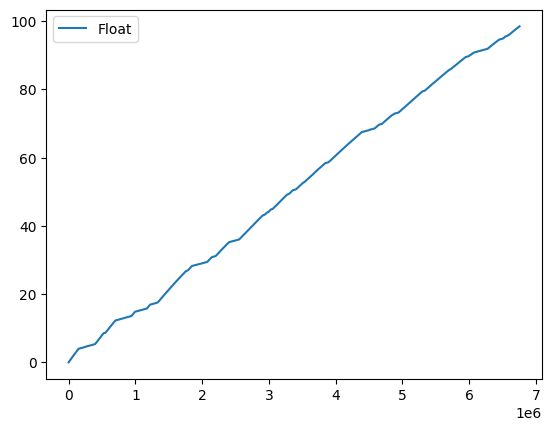

In [37]:
plt.plot(np.unique(ToA) / 1e9, label='Float')
plt.legend()

Found 1 hot pixels!
(array([123], dtype=int64), array([223], dtype=int64))
[124 224]
LED centred about [124 224]?


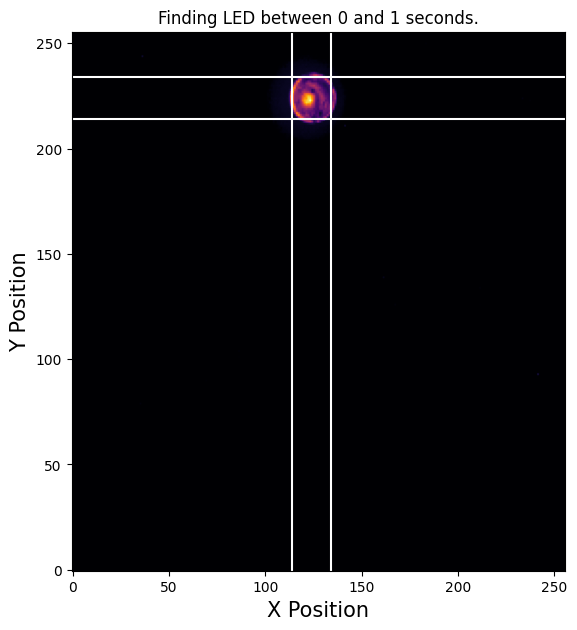

In [38]:
#Plot the 1st second to find your led shot
t1 = 0 #Start Time (s)
t2 = 1 #End Time (s)

#Setup the figure
fig = plt.figure(figsize=(14,7)) 
ax = fig.add_subplot(121)
ax.set_title(f'Finding LED between {t1} and {t2} seconds.')
ax.set_xlabel('X Position', fontsize=15)
ax.set_ylabel('Y Position', fontsize=15)

ot = np.argwhere((t1 * 10 ** 9 < ToA) & (ToA < t2 * 10 ** 9))                    # Set a threshold for the image ToA
xp, yp, zp = x_p[ot], y_p[ot], ToT[ot]                                           # Get pixels corresponding to ToA timeframe
data = np.hstack((xp, yp, zp))                                                   # Create a 3d array of our data
sorted_indices = np.lexsort((yp.flatten(), xp.flatten()))                        # Sort by y, then x
sorted_data = data[sorted_indices]                                               # Sort array by sorted indices
unique_rows, indices = np.unique(sorted_data[:, :2], axis=0, return_index=True)  # Find the unique rows and their indices
summed_third_column = np.add.reduceat(sorted_data[:, 2], indices)                # Add the zd data between each of the indices
image = np.zeros((256,256))                                                      # Create empty image array
image[unique_rows[:,0], unique_rows[:,1]] = summed_third_column                  # Fill image with summed intensities

#Find the 50 most intense pixels
s_img = np.sort(image.flatten())[-1000:]
result = grubbs_test(s_img, 0.05)
if result[0]:
    outliers = find_indices_numpy(image, result[-2])
    # image[outliers] = 0
    print(f'Found {outliers[0].shape[0]} hot pixels!')
    print(outliers)
ax.imshow(image.T, cmap = 'inferno', vmin = 0, vmax = 1.0*np.max(image), origin = 'lower', aspect = 'auto')
image[image < np.max(image) * 0.1] = 0
image[image > np.max(image) * 0.1] = 1
rcs = centroid_image(image)[0]
print(rcs)
print(f'LED centred about {rcs}?')

for x in (rcs[0]-10,rcs[0]+10):
    ax.axvline(x, color = 'w')

for y in (rcs[1]-10,rcs[1]+10):
    ax.axhline(y, color = 'w')

(17853699,) (20,)
Found 9852 LED trigger pulses.


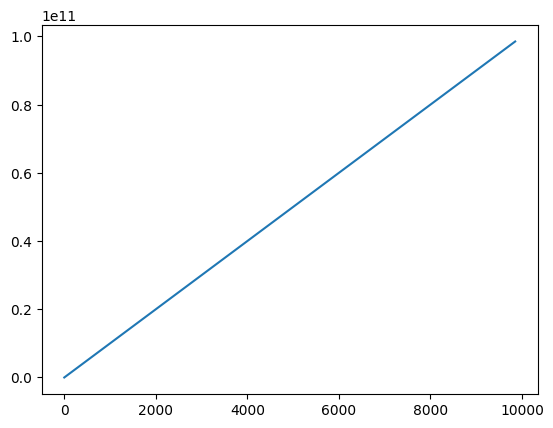

In [39]:
# # If you are not happy with the led centre value from above please set a new value on the following line and uncomment it
# rcs = [250, 205]

# Create a list of pixels to check for LED pulses
led_pixels_x = np.array([x for x in range(rcs[0]-10,rcs[0]+10)])
led_pixels_y = np.array([x for x in range(rcs[1]-10,rcs[1]+10)])
pixel_threshold = 20
# Get indices of led pixels to get the led time of arrivals, remove any values below the set threshold
ind = np.where(np.in1d(x_p,led_pixels_x) & (np.in1d(y_p,led_pixels_y)) & (ToT >= pixel_threshold))[0]
print(x_p.shape, led_pixels_x.shape)
pixel_ToA = np.unique(ToA[ind])
# DBSCAN parameters
eps = 10000.0  # How many ns do you want to cluster pixels by?
min_samples = 2  # Minimum number of pixels to form a cluster

# Apply DBSCAN
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(pixel_ToA.reshape(-1, 1))

# Get the labels
labels = clustering.labels_

# Extract clusters and find the lowest value in each cluster
clusters = {}
for label, point in zip(labels, pixel_ToA.flatten()):
    if label != -1:  # Exclude noise (outliers)
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(point)

# Find the lowest value in each cluster
shot_times = np.array([min(clusters[label]) for label in clusters])
print(f'Found {len(shot_times)} LED trigger pulses.')
plt.plot(shot_times)

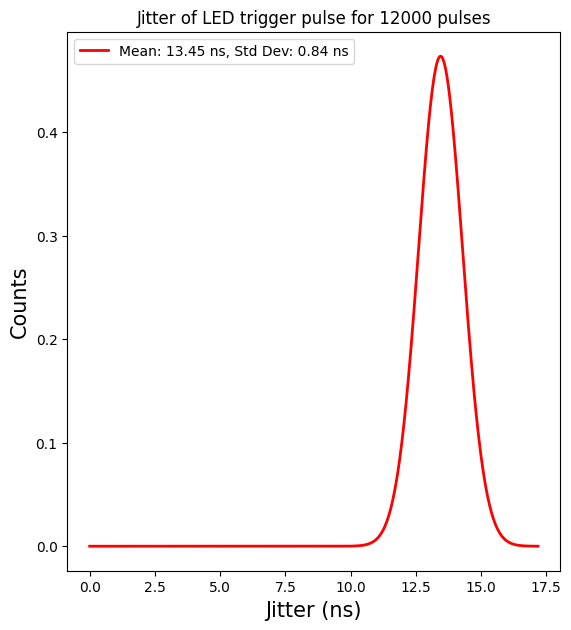

In [8]:
fig = plt.figure(figsize=(14,7)) 
ax = fig.add_subplot(121)
ax.set_title(f'Jitter of LED trigger pulse for {len(shot_times)} pulses')
ax.set_xlabel('Jitter (ns)', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
jitter = np.diff(shot_times)
jitter -= np.min(jitter)

# Fit a Gaussian Mixture Model with 1 component (i.e., a single Gaussian) to the filtered data
gmm = GaussianMixture(n_components=2)
gmm.fit(jitter.reshape(-1, 1))

# Retrieve the fitted mean and variance (covariance) of the Gaussian
mean = gmm.means_[0, 0]
variance = gmm.covariances_[0, 0]
std_dev = np.sqrt(variance)

# Generate x-values (range of values)
x_values = np.linspace(np.min(jitter), np.max(jitter), 1000)

# Compute the Gaussian function values
y_values = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - mean) / std_dev) ** 2)
plt.plot(x_values, y_values, color='r', linewidth=2, label = f'Mean: {mean:.2f} ns, Std Dev: {std_dev[0]:.2f} ns')
plt.legend()

In [108]:
x_data = []
y_data = []
ToT_data = []
ToA_data = []
frame_data = []
start_idx = 0
min_time = 0
max_time = 50000

for index in range(len(shot_times)+1):
    # For the last laser trigger there is no next trigger, set ending to end of array
    try:
        timing = shot_times[index]
        slice_end_idx = np.searchsorted(ToA, timing, side='right')
    except:
        slice_end_idx = -1
    # The 1st index is data before the first trigger pulse
    if index == 0:
        start_idx = slice_end_idx
        continue
    # Get the times that correspond to the laser pulse
    times = np.copy(ToA[start_idx:slice_end_idx])
    # Ignore the loop of no data in it
    if len(times) == 0: continue
    # Set time to be relative for each pulse
    times -= np.min(times)
    # Remove laser pulse data and noise outside of thresholds
    not_noise = np.where((min_time < times) & (times < max_time))
    ToA_data.append(times[not_noise].astype(np.float32))
    x_data.append(x_p[start_idx:slice_end_idx][not_noise])
    y_data.append(y_p[start_idx:slice_end_idx][not_noise])
    ToT_data.append(ToT[start_idx:slice_end_idx][not_noise])
    frame_data.append(np.array([index for _ in range(len(x_data[-1]))]))
    start_idx = slice_end_idx

print(f'Found {len(x_data)} image frames.')
print('Saving data to file, please wait...')

# Combine the arrays
x_data = np.concatenate([arr.flatten() for arr in x_data])
y_data = np.concatenate([arr.flatten() for arr in y_data])
ToT_data = np.concatenate([arr.flatten() for arr in ToT_data])
ToA_data = np.concatenate([arr.flatten() for arr in ToA_data])
frame_data = np.concatenate([arr.flatten() for arr in frame_data])

# Save data with compression
with h5py.File(f'{directory}/{output_filename}', 'w') as f:
    f.create_dataset('X', data=x_data, compression='gzip', compression_opts=4)
    f.create_dataset('Y', data=y_data, compression='gzip', compression_opts=4)
    f.create_dataset('ToA', data=ToA_data, compression='gzip', compression_opts=4)
    f.create_dataset('ToT', data=ToT_data, compression='gzip', compression_opts=4)
    f.create_dataset('Frame', data=frame_data, compression='gzip', compression_opts=4)
print('Finished saving data to file!')

Found 12000 image frames.
Saving data to file, please wait...
1
Finished saving data to file!


(0.0, 9.0)

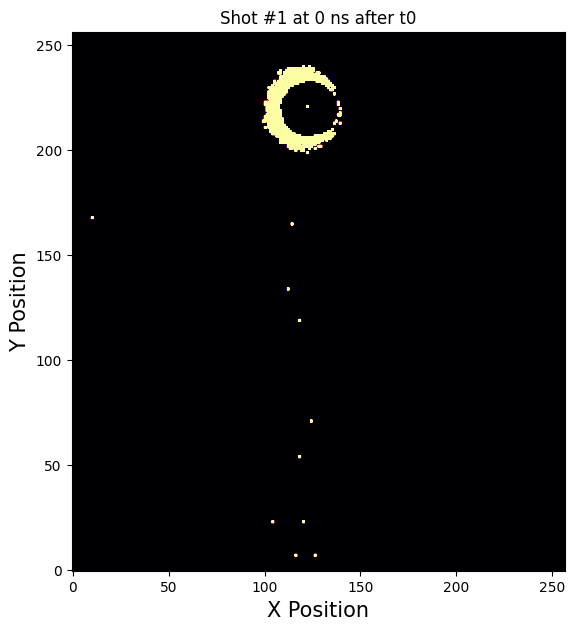

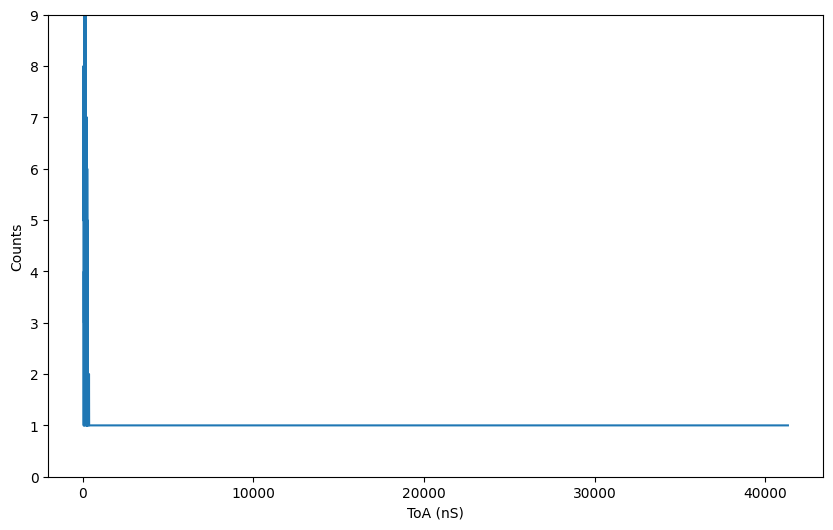

In [30]:
# Plots the first image
time_offset_from_t0 = 0
shot_index = 1

# Setup the figure
fig = plt.figure(figsize=(14,7)) 
ax = fig.add_subplot(121)

ax.set_title(f'Shot #{shot_index} at {time_offset_from_t0} ns after t0')
ax.set_xlabel('X Position', fontsize=15)
ax.set_ylabel('Y Position', fontsize=15)

image = np.zeros((257,257))
ot = np.argwhere((time_offset_from_t0 <= shot_data[shot_index]['ToA']) & (shot_data[shot_index]['ToA'] <= 1e5))[:,0]

xp, yp = shot_data[shot_index]['X'][ot], shot_data[shot_index]['Y'][ot]

for i, x in enumerate(xp):
    y = yp[i]
    image[x, y] = np.add(image[x, y], 1)

ax.imshow(image.T, cmap = 'inferno', vmin = 0,vmax = 0.1*np.max(image), origin = 'lower', aspect = 'auto')

#ToF spectrum
fig,ax = plt.subplots(figsize = (10,6))
x, y = np.unique(shot_data[shot_index]['ToA'][ot], return_counts=True)
ax.plot(x,y)
ax.set_xlabel('ToA (nS)')
ax.set_ylabel('Counts')

# ax.set_xlim(0,100)
# ax.set_xlim(0,1000)
ax.set_ylim(0,np.max(y))